In [1]:
import os
import sys

# 获取当前工作目录
current_dir = os.getcwd()
# 设置项目根目录
project_root = os.path.abspath(os.path.join(current_dir, ".."))
# 将项目根目录添加到sys.path
sys.path.insert(0, project_root)

In [2]:
import networkx as nx
from sentence_transformers import SentenceTransformer
from pre import html_processor

# model = SentenceTransformer("D:\\Workspace\\models\\bce-embedding-base_v1", device='cuda')


Document count in index 'aiops_v3': 131239
处理第1页数据
处理第1页数据
处理第1页数据
处理第1页数据
处理第1页数据
处理第1页数据
处理第1页数据
处理第1页数据
处理第1页数据
处理第1页数据
处理第1页数据
处理第1页数据
处理第1页数据
处理第1页数据
处理第1页数据
处理第1页数据
处理第1页数据



KeyboardInterrupt



In [ ]:
from utils import splitter

root_path = 'D:/Workspace/aiops2024-challenge-dataset/htmls/director'
data_models = html_processor.parse_xml(root_path + '/nodetree.xml', 'director')
print(f'要处理的文件数量: {len(data_models)}')
loop = 1
documents = []
for data_model in data_models:
    print(
        f'loop: {loop}, root: {data_model.root}, name: {data_model.name}, url: {data_model.url}, Doctype: {data_model.doctype}, Catalogs: {data_model.catalogs}')
    # 按照url去读取文件
    dst_url = root_path + '/documents/' + data_model.url
    
    content = html_processor.html_to_markdown(dst_url)
    if len(content) > 1024:
        document = {data_model.name: content}
    else:
        docs = splitter.split_markdown(content, max_length=1024)
        paragraphs = [doc.page_content for doc in docs]

In [ ]:

# 示例文档内容
documents = {
    "doc1": "素胚勾勒出青花笔锋浓转淡.\n而你嫣然地一笑如昙花绽放",
    "doc2": "天青色等烟雨\n而我在等你",
    "doc3": "古巴比伦王颁布了汉谟拉比法典刻在黑色的玄武岩距今已经三千七百多年\n你在橱窗前凝视碑文的字眼"
}

# 创建图并添加节点（段落为节点）
G = nx.Graph()
for doc_id, content in documents.items():
    paragraphs = content.split("\n")
    for i, paragraph in enumerate(paragraphs):
        node_id = f"{doc_id}_p{i+1}"
        G.add_node(node_id, text=paragraph)

# 示例：根据段落内容相似度添加边（可以根据实际需求计算相似度后添加）
G.add_edge("doc1_p1", "doc3_p1", text="Related content between doc1_p1 and doc3_p1")
G.add_edge("doc2_p1", "doc3_p2", text="Related content between doc2_p1 and doc3_p2")

# 计算节点和边的嵌入
def compute_text_embeddings(graph):
    node_embeddings = {}
    for node in graph.nodes(data=True):
        node_embeddings[node[0]] = model.encode(node[1]['text'])
    
    edge_embeddings = {}
    for edge in graph.edges(data=True):
        edge_embeddings[(edge[0], edge[1])] = model.encode(edge[2]['text'])
    
    return node_embeddings, edge_embeddings

node_embeddings, edge_embeddings = compute_text_embeddings(G)

In [12]:
import numpy as np

# 查询示例
query = "汉谟拉比法典"
query_embedding = model.encode(query)

# 计算相似度并检索最相关的k跳自我图
def retrieve_subgraphs(graph, query_embedding, node_embeddings, top_k=5):
    similarities = {}
    for node, embedding in node_embeddings.items():
        similarity = np.dot(query_embedding, embedding) / (np.linalg.norm(query_embedding) * np.linalg.norm(embedding))
        similarities[node] = similarity
    
    # 按相似度排序并选择前k个节点
    sorted_nodes = sorted(similarities.items(), key=lambda item: item[1], reverse=True)[:top_k]
    subgraphs = [nx.ego_graph(graph, node, radius=1) for node, _ in sorted_nodes]
    
    return subgraphs

subgraphs = retrieve_subgraphs(G, query_embedding, node_embeddings)


In [8]:
def soft_pruning(subgraphs, query_embedding, node_embeddings, edge_embeddings):
    pruned_subgraphs = []
    for subgraph in subgraphs:
        for node in list(subgraph.nodes):
            if np.dot(query_embedding, node_embeddings[node]) < 0.5:  # 阈值可以调整
                subgraph.remove_node(node)
        for edge in list(subgraph.edges(data=True)):
            if np.dot(query_embedding, edge_embeddings[(edge[0], edge[1])]) < 0.5:
                subgraph.remove_edge(edge[0], edge[1])
        pruned_subgraphs.append(subgraph)
    return pruned_subgraphs

pruned_subgraphs = soft_pruning(subgraphs, query_embedding, node_embeddings, edge_embeddings)


In [9]:
for subgraph in pruned_subgraphs:
    print(subgraph.nodes)

['doc3_p1']
[]
[]
['doc3_p1']
[]


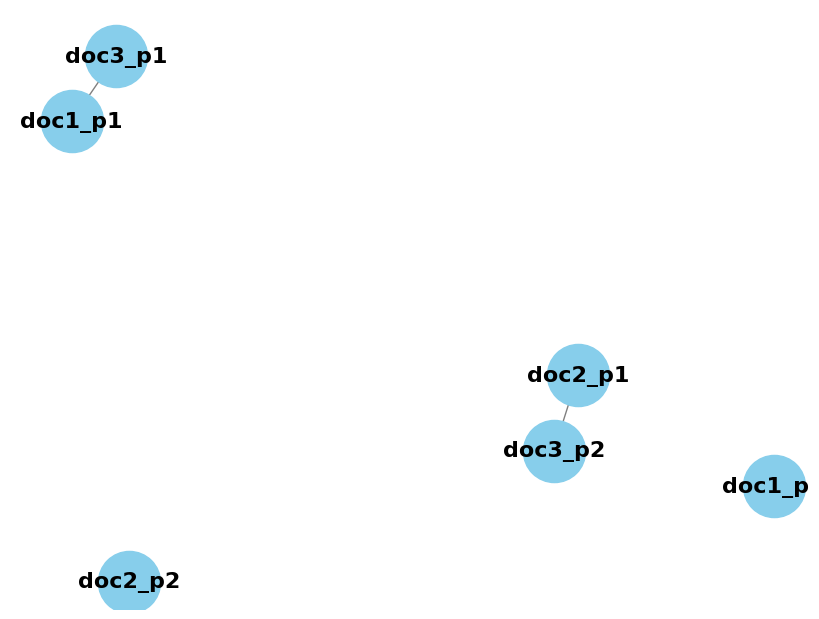

In [13]:
import networkx as nx
import matplotlib.pyplot as plt

# 创建一个示例图
# G = nx.Graph()
# G.add_node("A", label="Node A")
# G.add_node("B", label="Node B")
# G.add_edge("A", "B", weight=1)

# 绘制图并保存为图像文件
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=2000, font_size=16, font_weight='bold')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.savefig('graph.png')
plt.show()


In [2]:
from langchain.text_splitter import MarkdownHeaderTextSplitter
from utils.splitter import *


text = """
# 标题1
## 标题2
今天星期一
今天星期二
上的飞机到附件为
微软微软
"""
contents = split_markdown(text)
print(contents)
    
    

[{'content': '# 标题1\n## 标题2\n今天星期一\n今天星期二\n上的飞机到附件为\n微软微软', 'h1': '标题1', 'h2': '标题2'}]


In [22]:
from pre import html_processor

ModuleNotFoundError: No module named 'pre'